In [19]:
import pandas as pd

In [30]:
data = pd.read_csv('../Data/epsPQRS.csv', sep=';')
data

,Comentario,Area
0,pqrd-18-0674823nurc 1-2018-221502entidad: capi...,Negación De Servicios
1,pqrd-18-0675272nurc 1-2018-216612entidad: capi...,Negación De Servicios
2,pqrd-18-0675410nurc 1-2018-221583entidad: capi...,Dificultad Accesibilidad Administrativa
3,pqrd-18-0675530nurc 1-2018-217812entidad: capi...,Negación De Servicios
4,favor enviar copia al ministerio de salud y pr...,Dificultad Tutelas
...,...,...
77821,ss vacunas antigeno del virus de hepatitis b 2...,No Suministro Medicamentos
77822,apixaban 5 mg tableta,Otro
77823,ss solucion mipres 20201123175024488426,Negación De ServiciosDificultad MédicoAdmin
77824,ss implante de dispositivo en cornea asistido,Negación De ServiciosDificultad MédicoAdmin


In [31]:
data = data.sample(frac=0.5)

In [32]:
data.Area.value_counts(normalize=True)

Oportunidad Citas Red Contratada                  0.451469
No Suministro Medicamentos                        0.185722
Dificultad Accesibilidad Administrativa           0.121245
Inconsistencias Sistemas De InformacionAsegura    0.073754
Negación De ServiciosDificultad MédicoAdmin       0.055740
Dificultad Tutelas                                0.028679
Negación De Servicios                             0.026572
Incumplimiento Portabilidad Nacional              0.010228
Otro                                              0.007221
Problemas Recursos Economicos                     0.005756
Dificultad Alto Costo                             0.005499
Atención Deshumanizada                            0.005345
Exclusiones Usuarios Sin Tutela                   0.005114
Tramite Interno I                                 0.004703
Prestaciones Economicas                           0.004549
Cotizaciones Pau Rs                               0.004343
Presunto Evento Adverso SeguridadPertinencia      0.0026

In [33]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=0)

In [34]:
print(f'Tenemos {data.shape[0]} datos en total.')
print(f'El conjunto de entrenamiento (train) tiene {train.shape[0]} datos.')
print(f'El conjunto de prueba (test) tiene {test.shape[0]} datos.')

Tenemos 38913 datos en total.
El conjunto de entrenamiento (train) tiene 31130 datos.
El conjunto de prueba (test) tiene 7783 datos.


In [35]:
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
stopwords_sp = stopwords.words('spanish')

In [36]:
stopwords_sp.extend(["pqrd", "entidad", "nurc", "dia", "capital", "salud","bogotá"])
def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = texto.split() # Tokenizar
    texto = [palabra for palabra in texto if palabra not in stopwords_sp]
    texto = " ".join(texto)
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)

In [37]:
X_train = tfidf_vect.fit_transform(train.Comentario.values)
y_train = train.Area.values

In [38]:
X_test = tfidf_vect.transform(test.Comentario.values)
y_test = test.Area.values

In [39]:
print(f"Tamaño de X_train (entrenamiento): {pd.DataFrame(X_train.toarray()).shape}")
print(f"Tamaño de X_test (prueba): {pd.DataFrame(X_test.toarray()).shape}")
print(f"Tamaño de y_train {len(y_train)} y tamaño de y_test {len(y_test)}")

Tamaño de X_train (entrenamiento): (31130, 39107)
Tamaño de X_test (prueba): (7783, 39107)
Tamaño de y_train 31130 y tamaño de y_test 7783


In [40]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [41]:
# Inicializar los clasificadores
nb = MultinomialNB()
logreg = LogisticRegression(class_weight='balanced')
svm = LinearSVC(class_weight='balanced')
dt = DecisionTreeClassifier(class_weight='balanced')

In [42]:
# Entrenamos los modelos
nb.fit(X_train, y_train)
logreg.fit(X_train, y_train)
svm.fit(X_train, y_train)
dt.fit(X_train, y_train);

C:\Users\jrm20\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
y_pred_nb = nb.predict(X_test)
y_pred_logreg = logreg.predict(X_test)
y_pred_svm = svm.predict(X_test)
y_pred_dt = dt.predict(X_test)

In [44]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [46]:
print('Exactitud')
print( f'Naive Bayes: {accuracy_score(y_test, y_pred_nb):>15.2f}')
print( f'Regresión Logística: {accuracy_score(y_test, y_pred_logreg):>7.2f}')
print( f'SVM: {accuracy_score(y_test, y_pred_svm):>23.2f}')
print( f'Árbol de decisión: {accuracy_score(y_test, y_pred_dt):>9.2f}')

Exactitud
Naive Bayes:            0.60
Regresión Logística:    0.65
SVM:                    0.70
Árbol de decisión:      0.57


In [71]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
metricas = [precision_score, recall_score, f1_score]
for metrica in metricas:
    print(metrica.__name__)
    print(f"Naive Bayes: {metrica(y_test, y_pred_nb, labels= data.Area.values, average='weighted'):.2f}")
    print(f"Regresión Logística: {metrica(y_test, y_pred_logreg, labels= data.Area.values, average='weighted'):.2f}")
    print(f"SVM: {metrica(y_test, y_pred_svm, labels= data.Area.values, average='weighted'):.2f}")
    print(f"Árbol de decisión: {metrica(y_test, y_pred_dt, labels= data.Area.values, average='weighted'):.2f}")
    print()

precision_score
Naive Bayes: 0.60
Regresión Logística: 0.87


C:\Users\jrm20\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM: 0.84
Árbol de decisión: 0.71

recall_score
Naive Bayes: 0.85
Regresión Logística: 0.71
SVM: 0.80
Árbol de decisión: 0.67

f1_score
Naive Bayes: 0.67
Regresión Logística: 0.78
SVM: 0.82
Árbol de decisión: 0.69



In [74]:
print('Naive Bayes')
print(classification_report(y_test, y_pred_nb, zero_division=1))
print()

Naive Bayes
                                                precision    recall  f1-score   support

                        Atención Deshumanizada       1.00      0.00      0.00        37
                           Cotizaciones Pau Rs       1.00      0.00      0.00        35
       Dificultad Accesibilidad Administrativa       0.68      0.31      0.42      1008
                         Dificultad Alto Costo       1.00      0.00      0.00        43
                            Dificultad Tutelas       1.00      0.00      0.00       225
               Exclusiones Usuarios Sin Tutela       1.00      0.00      0.00        31
Inconsistencias Sistemas De InformacionAsegura       0.86      0.29      0.44       534
          Incumplimiento Portabilidad Nacional       1.00      0.00      0.00        99
                         Negación De Servicios       1.00      0.00      0.00       209
   Negación De ServiciosDificultad MédicoAdmin       0.82      0.03      0.06       421
                   

In [76]:
print('Regresion Logistica')
print(classification_report(y_test, y_pred_logreg, zero_division=1))
print()

Regresion Logistica
                                                precision    recall  f1-score   support

                        Atención Deshumanizada       0.20      0.54      0.29        37
                           Cotizaciones Pau Rs       0.08      0.23      0.12        35
       Dificultad Accesibilidad Administrativa       0.65      0.41      0.51      1008
                         Dificultad Alto Costo       0.10      0.40      0.16        43
                            Dificultad Tutelas       0.28      0.54      0.37       225
               Exclusiones Usuarios Sin Tutela       0.05      0.35      0.08        31
Inconsistencias Sistemas De InformacionAsegura       0.66      0.79      0.71       534
          Incumplimiento Portabilidad Nacional       0.51      0.60      0.55        99
                         Negación De Servicios       0.31      0.57      0.40       209
   Negación De ServiciosDificultad MédicoAdmin       0.37      0.51      0.43       421
           

In [77]:
print('SVM')
print(classification_report(y_test, y_pred_svm,zero_division=1))
print()

SVM
                                                precision    recall  f1-score   support

                        Atención Deshumanizada       0.21      0.35      0.26        37
                           Cotizaciones Pau Rs       0.05      0.09      0.07        35
       Dificultad Accesibilidad Administrativa       0.63      0.49      0.55      1008
                         Dificultad Alto Costo       0.14      0.23      0.18        43
                            Dificultad Tutelas       0.31      0.36      0.33       225
               Exclusiones Usuarios Sin Tutela       0.07      0.26      0.11        31
Inconsistencias Sistemas De InformacionAsegura       0.67      0.81      0.73       534
          Incumplimiento Portabilidad Nacional       0.53      0.57      0.55        99
                         Negación De Servicios       0.35      0.42      0.38       209
   Negación De ServiciosDificultad MédicoAdmin       0.43      0.46      0.45       421
                    No Sumi

In [78]:
print('Árbol de decisión')
print(classification_report(y_test, y_pred_dt, zero_division=1))
print()

Árbol de decisión
                                                precision    recall  f1-score   support

                        Atención Deshumanizada       0.17      0.41      0.24        37
                           Cotizaciones Pau Rs       0.05      0.11      0.07        35
       Dificultad Accesibilidad Administrativa       0.45      0.38      0.42      1008
                         Dificultad Alto Costo       0.03      0.05      0.04        43
                            Dificultad Tutelas       0.21      0.23      0.22       225
               Exclusiones Usuarios Sin Tutela       0.03      0.13      0.05        31
Inconsistencias Sistemas De InformacionAsegura       0.53      0.55      0.54       534
          Incumplimiento Portabilidad Nacional       0.41      0.42      0.42        99
                         Negación De Servicios       0.24      0.26      0.25       209
   Negación De ServiciosDificultad MédicoAdmin       0.31      0.34      0.32       421
             

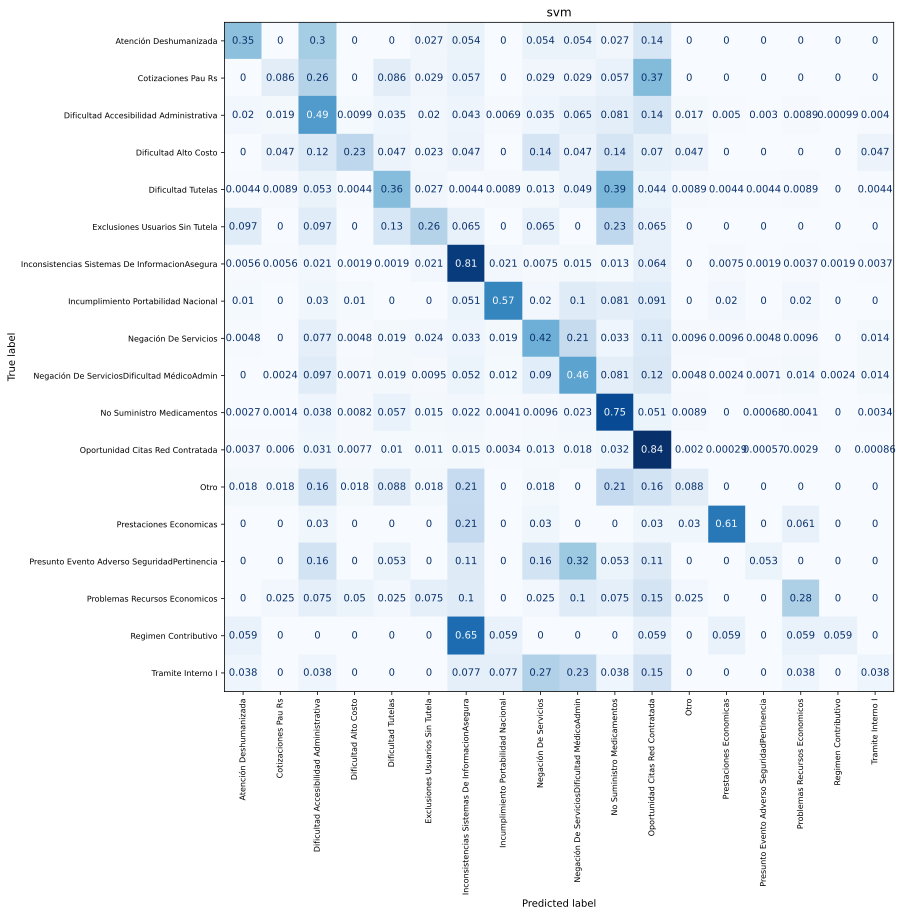

In [83]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize = (15, 15))
plot_confusion_matrix(svm, X_test, y_test, cmap="Blues", ax=ax, normalize='true').im_.colorbar.remove()
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.title("svm")
plt.show()

In [84]:
# Resultados
nuevos = ['diagnóstico posible derrame interno se encuentra hospitalizado en la ips hospital de san',
          'Tengo mucho dolor de cabeza y necesito atencion', 
          'Estoy solicitando una cita desde hace mucho tiempo']
nuevos_trans = tfidf_vect.transform(nuevos)

In [85]:
print(nb.predict(nuevos_trans))

['Oportunidad Citas Red Contratada' 'Oportunidad Citas Red Contratada'
 'Oportunidad Citas Red Contratada']


In [86]:
print(logreg.predict(nuevos_trans))

['Negación De Servicios' 'Presunto Evento Adverso SeguridadPertinencia'
 'Oportunidad Citas Red Contratada']


In [87]:
print(svm.predict(nuevos_trans))

['Negación De Servicios' 'Dificultad Accesibilidad Administrativa'
 'Oportunidad Citas Red Contratada']


In [88]:
print(dt.predict(nuevos_trans))

['Negación De Servicios' 'Dificultad Accesibilidad Administrativa'
 'Inconsistencias Sistemas De InformacionAsegura']
